In [1]:
chars_list = []
def readchars(line):
    for c in line:
        if not c in chars_list:
            chars_list.append(c)

# 太宰治の「惜別」を読み込んで見る
text = ''
with open('dazai.txt', encoding='utf-8') as f:
    text = f.read()
    readchars(text)

n_chars = len(chars_list)
print('文字種 : ', n_chars)  # 2454 種類の文字があるらしい
print('文字数 : ', len(text))

文字種 :  2154
文字数 :  91002


In [2]:
chars_list = sorted(list(set(text)))
n_chars = len(chars_list)
print('文字数(重複なし) : ', n_chars)

# 辞書作成
# 文字->インデックス値
char_to_index = {}
# インデックス->文字
index_to_char = {}
for i, char in enumerate(chars_list):
    char_to_index[char] = i
    index_to_char[i] = char

文字数(重複なし) :  2154


In [3]:
# パラメータ & データ加工
n_time = 20  # 時系列の数
n_mid = 128  # 中間層のニューロン数
clip_const = 0.02  # ノルムの最大値を決める定数
beta = 2     # 確率分布の狭さ（次の文字の確定時に使用）

eta = 0.01   # 学習係数
epoch = 50   # 学習セット回数
batch_size = 128 # 1エポックあたりの処理回数

In [4]:
# 時系列データ
seq_chars = []  
next_chars = []
for i in range(0, len(text) - n_time):
    seq_chars.append(text[i: i + n_time])
    next_chars.append(text[i + n_time])

In [5]:
import numpy as np

# one-hot 表現化
input_data = np.zeros((len(seq_chars), n_time, n_chars), dtype=bool)
correct_data = np.zeros((len(seq_chars), n_chars), dtype=bool)
for i, chars in enumerate(seq_chars):
    correct_data[i, char_to_index[next_chars[i]]] = 1
    for j, char in enumerate(chars):
        input_data[i, j, char_to_index[char]] = 1


In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def clip_grad(grads, max_norm):
    norm = np.sqrt(np.sum(grads*grads))
    r = max_norm / norm
    if r < 1:
        clipped_grads = grads * r
    else:
        clipped_grads = grads
    return clipped_grads

class LSTMLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(4, n_upper, n) / np.sqrt(n_upper)
        self.v = np.random.randn(4, n, n) / np.sqrt(n)
        self.b = np.zeros((4, n))

    def forward(self, x, y_prev, c_prev):  # y_prev, c_prev: 前の時刻の出力と記憶セル
        u = np.matmul(x, self.w) + np.matmul(y_prev, self.v) + self.b.reshape(4, 1, -1)

        a0 = sigmoid(u[0])  # 忘却ゲート
        a1 = sigmoid(u[1])  # 入力ゲート
        a2 = np.tanh(u[2])  # 新しい記憶
        a3 = sigmoid(u[3])  # 出力ゲート
        self.gates = np.stack((a0, a1, a2, a3))

        self.c = a0*c_prev + a1*a2  # 記憶セル
        self.y = a3 * np.tanh(self.c)  # 出力
    
    def backward(self, x, y, c, y_prev, c_prev, gates, grad_y, grad_c, ):   
        a0, a1, a2, a3 = gates
        tanh_c = np.tanh(c)
        r = grad_c + (grad_y*a3) * (1-tanh_c**2)

        # 各delta
        delta_a0 = r * c_prev * a0 * (1-a0)
        delta_a1 = r * a2 * a1 * (1-a1)
        delta_a2 = r * a1 * (1 - a2**2)
        delta_a3 = grad_y * tanh_c * a3 * (1 - a3)

        deltas = np.stack((delta_a0, delta_a1, delta_a2, delta_a3))

        # 各パラメータの勾配
        self.grad_w += np.matmul(x.T, deltas)
        self.grad_v += np.matmul(y_prev.T, deltas)
        self.grad_b += np.sum(deltas, axis=1)

        # xの勾配
        grad_x = np.matmul(deltas, self.w.transpose(0, 2, 1))
        self.grad_x = np.sum(grad_x, axis=0)

        # y_prevの勾配
        grad_y_prev = np.matmul(deltas, self.v.transpose(0, 2, 1))
        self.grad_y_prev = np.sum(grad_y_prev, axis=0)
        
        # c_prevの勾配
        self.grad_c_prev = r * a0

    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b

    def clip_grads(self, clip_const):
        self.grad_w = clip_grad(self.grad_w, clip_const*np.sqrt(self.grad_w.size))
        self.grad_v = clip_grad(self.grad_v, clip_const*np.sqrt(self.grad_v.size))


In [7]:

# 全結合 出力層
class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # Xavierの初期値
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1).reshape(-1, 1)  # ソフトマックス関数

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T) 

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

In [8]:

# -- 各層の初期化 --
lstm_layer = LSTMLayer(n_chars, n_mid)
output_layer = OutputLayer(n_mid, n_chars)

# -- 訓練 --
def train(x_mb, t_mb):
    # 順伝播 LSTM層
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    c_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    gates_rnn = np.zeros((4, len(x_mb), n_time, n_mid))
    y_prev = y_rnn[:, 0, :]
    c_prev = c_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        lstm_layer.forward(x, y_prev, c_prev)

        y = lstm_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y

        c = lstm_layer.c
        c_rnn[:, i+1, :] = c
        c_prev = c

        gates = lstm_layer.gates
        gates_rnn[:, :, i, :] = gates

    # 順伝播 出力層
    output_layer.forward(y)

    # 逆伝播 出力層
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x
    grad_c = np.zeros_like(lstm_layer.c)

    # 逆伝播 LSTM層
    lstm_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        c = c_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        c_prev = c_rnn[:, i, :]
        gates = gates_rnn[:, :, i, :] 

        lstm_layer.backward(x, y, c, y_prev, c_prev, gates, grad_y, grad_c)
        grad_y = lstm_layer.grad_y_prev
        grad_c = lstm_layer.grad_c_prev

    # パラメータの更新
    lstm_layer.clip_grads(clip_const)
    lstm_layer.update(eta)
    output_layer.update(eta)

# -- 予測 --
def predict(x_mb):
    # 順伝播 LSTM層
    y_prev = np.zeros((len(x_mb), n_mid))
    c_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        lstm_layer.forward(x, y_prev, c_prev)
        y = lstm_layer.y
        y_prev = y
        c = lstm_layer.c
        c_prev = c

    # 順伝播 出力層
    output_layer.forward(y)
    return output_layer.y

# -- 誤差を計算 --
def get_error(x, t):
    limit = 1000
    if len(x) > limit:  # 測定サンプル数の上限を設定
        index_random = np.arange(len(x))
        np.random.shuffle(index_random)
        x = x[index_random[:limit], :]
        t = t[index_random[:limit], :]
    y = predict(x)
    return -np.sum(t*np.log(y+1e-7))/batch_size  # 交差エントロピー誤差

def create_text():
    genetate_text(text[0:n_time])

def genetate_text(prev_text):
    created_text = prev_text  # 生成されるテキスト
    print("Seed:", created_text)

    for i in range(200):  # 200文字の文章を生成
        # 入力をone-hot表現に
        x = np.zeros((1, n_time, n_chars))
        for j, char in enumerate(prev_text):
            x[0, j, char_to_index[char]] = 1
        
        # 予測を行い、次の文字を得る
        y = predict(x)
        p = y[0] ** beta  # 確率分布の調整
        p = p / np.sum(p)  # pの合計を1に
        next_index = np.random.choice(len(p), size=1, p=p)
        next_char = index_to_char[int(next_index[0])]
        created_text += next_char
        prev_text = prev_text[1:] + next_char

    print(created_text)
    print()  # 改行
    

error_record = []
n_batch = len(input_data) // batch_size  # 1エポックあたりのバッチ数
for i in range(epoch):
        
    # -- 学習 -- 
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)  # インデックスをシャッフルする
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)

        # -- 経過の表示 -- 
        print("\rEpoch: "+str(i+1)+"/"+str(epoch)+"  "+str(j+1)+"/"+str(n_batch), end="")

    # -- 誤差を求める --
    error = get_error(input_data, correct_data)
    error_record.append(error)
    print("  Error: "+str(error))

    # 経過の表示
    if i % 10 == 0:
        create_text()

Epoch: 1/50  710/710  Error: 38.97258947692782
Seed: これは日本の東北地方の某村に開業している
これは日本の東北地方の某村に開業している。のであしよ。のとたののでは、しかないかないる。といかいか、そ生のの自にその私にに順ていて、のにんはにってっていい。ではすりいるのでは、そのんえは、のをは、十んのうな、如をんのきしうのちので、といるでと時いた。どは、そのれしているのでは、いでないた。できいう。このでは、そのは、そんののとををたのでにといていいい。かのど事のは、そのは、といんで、心とないた。で、そんうで、さんにのですあうで、そにゃな

Epoch: 2/50  710/710  Error: 34.39835928539666
Epoch: 3/50  710/710  Error: 33.02278256791253
Epoch: 4/50  710/710  Error: 30.66948375145542
Epoch: 5/50  710/710  Error: 30.102979784415012
Epoch: 6/50  710/710  Error: 29.184388438857415
Epoch: 7/50  710/710  Error: 28.772327419422318
Epoch: 8/50  710/710  Error: 27.653971654248657
Epoch: 9/50  710/710  Error: 27.03715897889949
Epoch: 10/50  710/710  Error: 27.902229039472243
Epoch: 11/50  710/710  Error: 27.03339931626056
Seed: これは日本の東北地方の某村に開業している
これは日本の東北地方の某村に開業しているのです。」
　私はその日本のは、日本のの御の中ではないから、その時の同一の事を見て、この事には、その時には、その時の中のたちは、その日本の本人のようにも、自分のたちは、その日本の革命の思想のおいです。」という事になった。それですから、それは、私の下宿の小さんなのだから、それでも、その頃のお事を、それでも、それからも、私の周さんのおめて、そのようです。」ともう

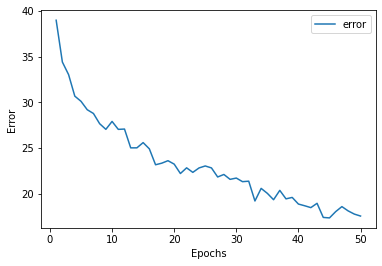

Seed: さあ、どうしようか。スパイの可能性は避け
Seed: さあ、どうしようか。スパイの可能性は避け
さあ、どうしようか。スパイの可能性は避ける、となるかと言えない。日本の一般の家庭では、そのうちに、周さんと逢ったりして、そうして、日本へ来てばかりにいたが、津田氏とったくなったら、いいかね。」と先生はクラスの者たちに、そこそは明治の高い者のかくをうしている。それに、自分はその日、とっと呼びと言い、そのごろ、その後にはじると、そのような青いやがり得るだ。
　　雲ちょっと笑いなかったのです。僕は、このごろ、山の毒です。お父さんは、それに書き

None


In [9]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(error_record)+1), error_record, label="error")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()
plt.show()


print('Seed: さあ、どうしようか。スパイの可能性は避け')
print(genetate_text('さあ、どうしようか。スパイの可能性は避け'))

In [10]:
print(genetate_text('これは日本の東北地方の某村に開業している'))

Seed: これは日本の東北地方の某村に開業している
これは日本の東北地方の某村に開業しているのだ。自分の下宿には何も何とか、一面親しく、一つとり、周さんと逢って置かれていたのですが、そうして、大丈夫かね。私の顔を見ると、私はそれに対して、たしかにおそのように思われた。そうして、あの人たちには、その一時の松島に於ける事が多くりにならぬ振りをしていた。それに、自分はその日本の一群の蘭学のお客になって、それに、また、あんなことしていました。そうして、日本へ来ても、それにならざるを得ないような気

None
